# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт необходимых библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler 

### Осмотр данных

В файлах находятся данные геологоразведки трёх регионов.

Описание данных:

    id — уникальный идентификатор скважины;

    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

    product — объём запасов в скважине (тыс. баррелей).

In [2]:
geo_1 = pd.read_csv('/datasets/geo_data_0.csv') # загрузим данные и посмотрим на них
geo_2 = pd.read_csv('/datasets/geo_data_1.csv')
geo_3 = pd.read_csv('/datasets/geo_data_2.csv')
display(geo_1.head())
display(geo_2.head())
display(geo_3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [3]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
geo_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Судя по информации пропусков нет, но проверим.

In [6]:
print(geo_1.isna().sum())
print(geo_2.isna().sum())
print(geo_3.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Пропусков нет и это хорошо, облегчает работу по предобработке данных.  Посмотрим на наличие явных дубликатов.

In [7]:
print(geo_1.duplicated().sum())
print(geo_2.duplicated().sum())
print(geo_3.duplicated().sum())

0
0
0


Явных дубликатов тоже нет. 

Посмотрим на гистограммы и числовые описания данных

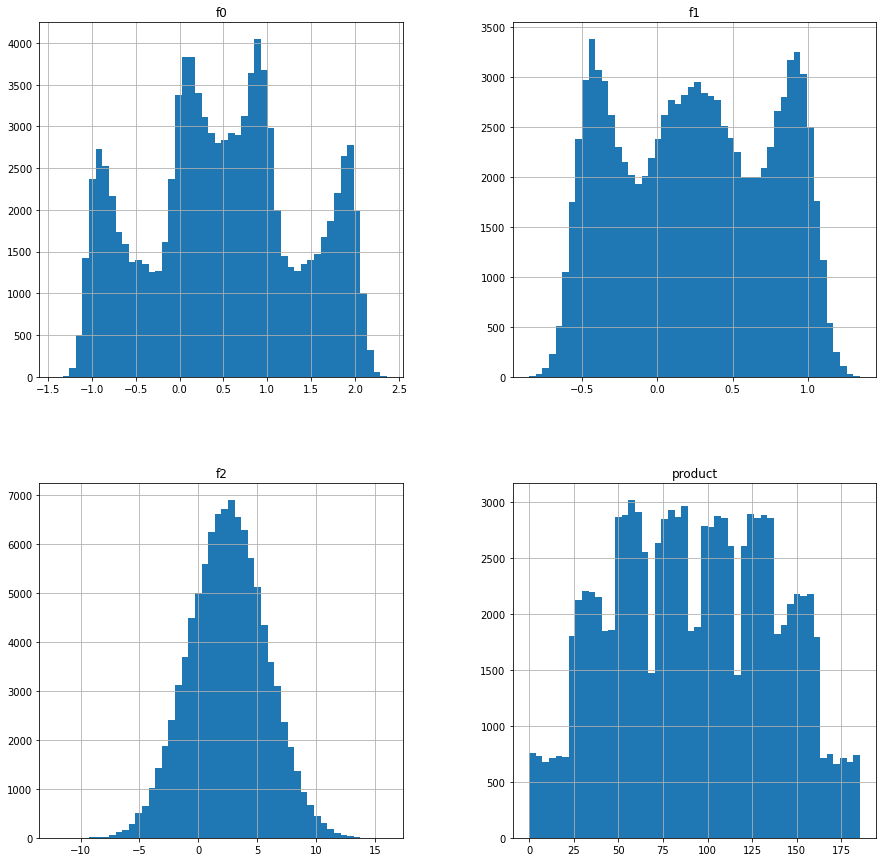

In [8]:
geo_1.hist(bins=50, figsize=(15,15));

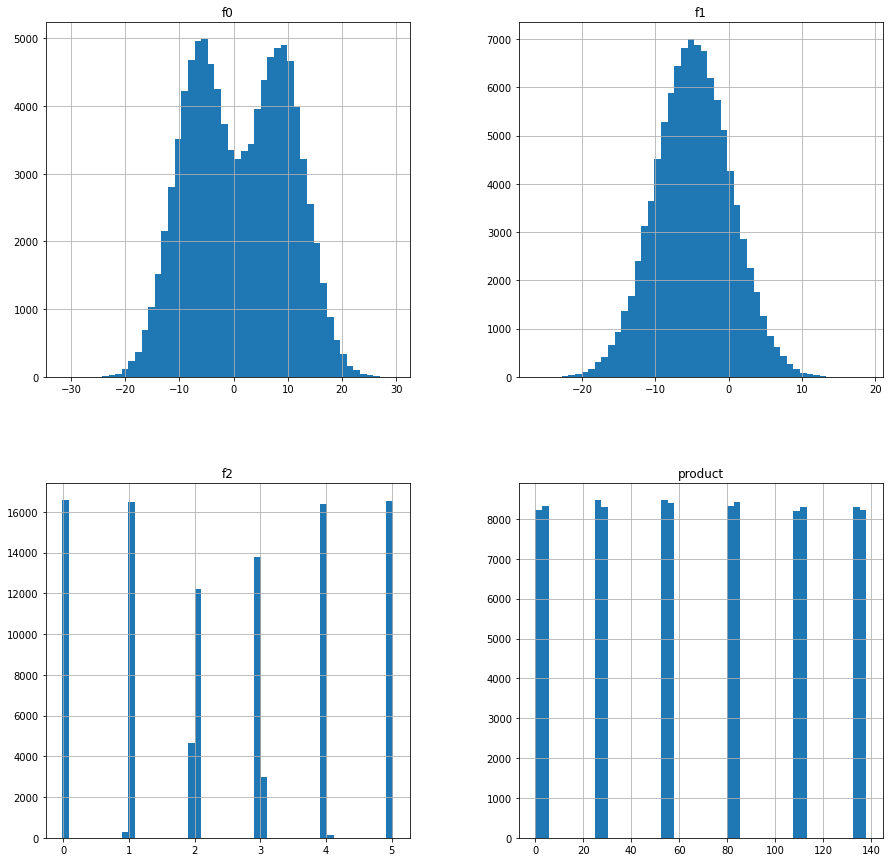

In [9]:
geo_2.hist(bins=50, figsize=(15,15));

Не зная смысловой нагрузки признаков f0, f1, f2, смотреть на их гистограммы занятие так себе, но всё же у второго региона f2  и product(объём запасов в скважине (тыс. баррелей)) явно отличаются от остальных регионов. Данные как будто классифицированы и имеют схожие значения по количеству. Но с чем это связано мне лично не понятно, мало "вводных" в задании. 

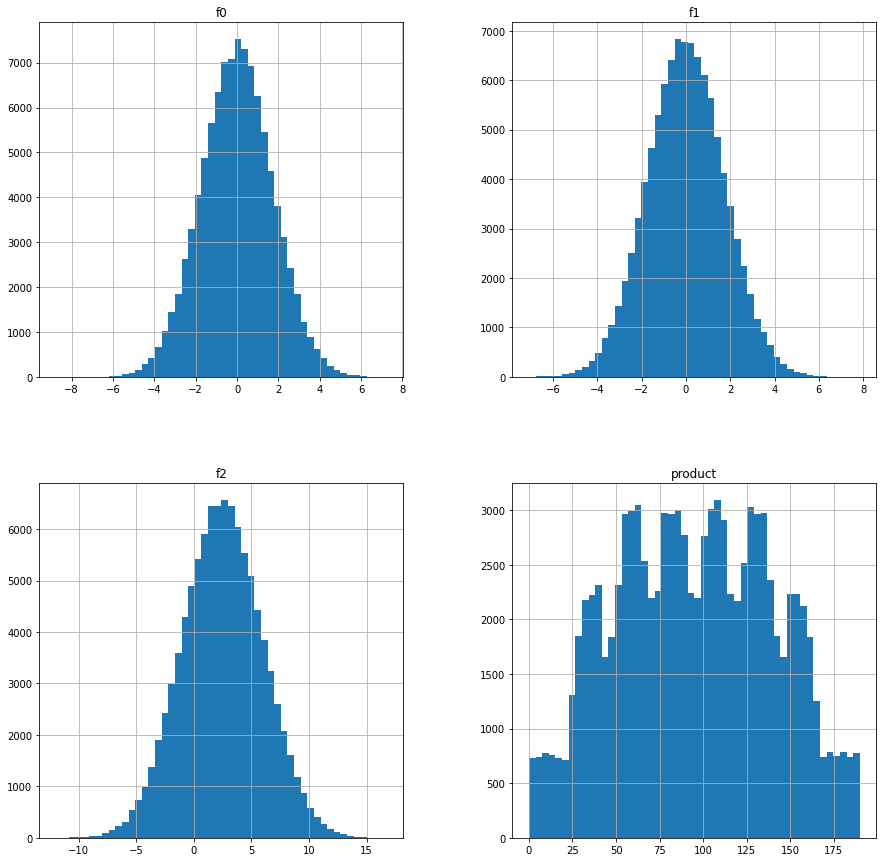

In [10]:
geo_3.hist(bins=50, figsize=(15,15));

In [11]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [12]:
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [13]:
geo_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### Вывод

Все три таблицы имеют одинаковую структуру и одинаковое количество данных (по 100 000).

Пропуски и явные дубликаты в данных отсутствуют.

Были выявлены "странности" на гистограммах f2 и product второго региона, но на сколько это важно пока не понятно.

Признаки f0, f1, f2, product - количественные. Признак id - категориальный.

Признак id (уникальный идентификатор скважины) не будет использоваться в исследование, поле можно удалить.


## Обучение и проверка модели

В качестве модели будет использоваться модель линейной регрессии.

Данные будут делится на обучающую и валидационную выборки в соотношении 75:25.

Признаки - f0, f1, f2.

Целевой признак - product.

### Первый регион

Для начала разбиваем данные на обучающие и целевые признаки, заодно удаляя лишний столбец.

In [14]:
features_geo_1 = geo_1.drop(['id', 'product'], axis=1)
target_geo_1 = geo_1['product']

Масштабируем

In [23]:
def mashtab(features_train, features_valid):
    numeric=['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric]) 
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    return features_train, features_valid

Разделим их на обучающие и валидационную в соотношении 75:25

In [24]:
features_train_geo_1, features_valid_geo_1, target_train_geo_1, target_valid_geo_1  = train_test_split(
    features_geo_1, 
    target_geo_1, 
    train_size=0.75, random_state=12345)


# Сразу посмотрим на правильность разделения
print('количество строк в features_train_geo_1: ', features_train_geo_1.shape[0])
print('количество строк в target_train_geo_1: ', target_train_geo_1.shape[0])
print('количество строк в features_valid_geo_1: ', features_valid_geo_1.shape[0])
print('количество строк в target_valid_geo_1: ', target_valid_geo_1.shape[0])

количество строк в features_train_geo_1:  75000
количество строк в target_train_geo_1:  75000
количество строк в features_valid_geo_1:  25000
количество строк в target_valid_geo_1:  25000


Обучим модель и найдем среднее значение предсказанных запасов, а также среднюю квадратичную ошибку

In [25]:
features_train_geo_1, features_valid_geo_1 = mashtab(features_train_geo_1, features_valid_geo_1)

model = LinearRegression()
model.fit(features_train_geo_1, target_train_geo_1)
predicted_valid_1 = model.predict(features_valid_geo_1)
mean_prediction_1 = predicted_valid_1.mean()
mse_1 = mean_squared_error(target_valid_geo_1, predicted_valid_1)
rmse_1 = mse_1**0.5
location = 'Первый регион'

#Создаю таблицу для удобства просмотра резуультатов
tablo = [[location, round(mean_prediction_1, 3), round(rmse_1, 2)]]
results = pd.DataFrame(tablo, columns=["Геолокация", "Средний запас", "Среднеквадратичная ошибка"])



print('Средний запас предсказанного сырья:', round(mean_prediction_1, 3), '(тыс. барелей)')
print('Среднеквадратическая ошибка RMSE:', round(rmse_1, 2))

Средний запас предсказанного сырья: 92.593 (тыс. барелей)
Среднеквадратическая ошибка RMSE: 37.58


/tmp/ipykernel_31/1171278908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

### Второй регион

Сделаем всё по аналогии как с первым регионом

In [27]:
features_geo_2 = geo_2.drop(['id', 'product'], axis=1)
target_geo_2 = geo_2['product']


features_train_geo_2, features_valid_geo_2, target_train_geo_2, target_valid_geo_2  = train_test_split(
    features_geo_2, 
    target_geo_2, 
    train_size=0.75, random_state=12345)

features_train_geo_2, features_valid_geo_2 = mashtab(features_train_geo_2, features_valid_geo_2)

model = LinearRegression()
model.fit(features_train_geo_2, target_train_geo_2)
predicted_valid_2 = model.predict(features_valid_geo_2)
mean_prediction_2 = predicted_valid_2.mean()
mse_2 = mean_squared_error(target_valid_geo_2, predicted_valid_2)
rmse_2 = mse_2**0.5
location = 'Второй регион'

new_index = {"Геолокация":location, "Средний запас":round(mean_prediction_2, 3), "Среднеквадратичная ошибка":round(rmse_2, 2)}
results = results.append(new_index, ignore_index=True)

print('Средний запас предсказанного сырья:', round(mean_prediction_2, 3), '(тыс. барелей)')
print('Среднеквадратическая ошибка RMSE:', round(rmse_2, 2))

Средний запас предсказанного сырья: 68.729 (тыс. барелей)
Среднеквадратическая ошибка RMSE: 0.89


/tmp/ipykernel_31/1171278908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

### Третий регион

Полная аналогия с предыдущими

In [28]:
features_geo_3 = geo_3.drop(['id', 'product'], axis=1)
target_geo_3 = geo_3['product']


features_train_geo_3, features_valid_geo_3, target_train_geo_3, target_valid_geo_3  = train_test_split(
    features_geo_3, 
    target_geo_3, 
    train_size=0.75, random_state=12345)

features_train_geo_3, features_valid_geo_3 = mashtab(features_train_geo_3, features_valid_geo_3)

model = LinearRegression()
model.fit(features_train_geo_3, target_train_geo_3)
predicted_valid_3 = model.predict(features_valid_geo_3)
mean_prediction_3 = predicted_valid_3.mean()
mse_3 = mean_squared_error(target_valid_geo_3, predicted_valid_3)
rmse_3 = mse_3**0.5

location = 'Третий регион'

new_index = {"Геолокация":location, "Средний запас":round(mean_prediction_3, 3), "Среднеквадратичная ошибка":round(rmse_3, 2)}
results = results.append(new_index, ignore_index=True)

print('Средний запас предсказанного сырья:', round(mean_prediction_3, 3), '(тыс. барелей)')
print('Среднеквадратическая ошибка RMSE:', round(rmse_3, 2))

Средний запас предсказанного сырья: 94.965 (тыс. барелей)
Среднеквадратическая ошибка RMSE: 40.03


/tmp/ipykernel_31/1171278908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

### Вывод

Взглянем на результаты

In [29]:
results

,Геолокация,Средний запас,Среднеквадратичная ошибка
0,Первый регион,92.593,37.58
1,Второй регион,68.729,0.89
2,Третий регион,94.965,40.03


Самый высокий показатель среднего запаса пресказанного сырья 94.965 у третьего региона, но здесь довольно высокое значение среднеквадратической ошибки RMSE равное 40,03.

У Первого региона показатели немного ниже, чем у Третьего региона, но по соотношению здесь ситуация аналогичная Третьему региону - довольно высокая RMSE.

У Второго региона показатель среднего запаса предсказанного сырья 68,729 самый низкий, но значение среднеквадратической ошибки RMSE всего 0,89, т.е. разброс значений гораздо меньше, чем у Первого и Третьего регионов.

Исходя из полученных значений, предварительно можно сказать, что Второй регион является самым предсказуемым для разработки, т.к. предсказанное значение запаса сырья во всех его скважинах примерно одинаковое.

## Подготовка к расчёту прибыли

###  Все ключевые значения для расчётов сохраненный в отдельные переменные 

In [30]:
number_of_points = 500    # число точек, которое исследуют при разведке региона
best_points = 200  # число лучших точек для разработки
budget = 10**10          # бюджет на разработку скважин в регионе в рублях
income_per_item = 450000  # доход с каждой единицы продукта в рублях
risk = 0.025             # максимальная вероятность убытков 

### Рассчет достаточного объёма сырья для безубыточной разработки новой скважины.

In [31]:
min_product = budget / (best_points * income_per_item)
print(round(min_product, 3), 'тыс. баррелей')

111.111 тыс. баррелей


###  Вывод

Достаточный объём сырья для безубыточной разработки новой скважины составляет 111 тыс. барелей. Рассчитанный объём сырья превышает средние значения запасов скважин во всех исследуемых регионах.

## Расчёт прибыли и рисков 

### Расчет валовой прибыли 200 лучших скважин регионов

Составим функцию для расчета валовой прибыли 200 лучших скважин регионов. 

In [32]:
def revenue(target, probabilities, count):
    target = target.reset_index(drop=True)
    probabilities = pd.Series(probabilities)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = (target[probs_sorted.index][:count]) * income_per_item
    return selected.sum() - budget


In [33]:
print("Валовая прибыль с 200 лучших скважин в Первом регионе:",
      '{0:,}'.format(int(revenue(target_valid_geo_1, predicted_valid_1, best_points))).replace(',', ' '), 'руб.')
print("Валовая прибыль с 200 лучших скважин во Втором регионе:",
      '{0:,}'.format(int(revenue(target_valid_geo_2, predicted_valid_2, best_points))).replace(',', ' '), 'руб.')
print("Валовая прибыль с 200 лучших скважин в Третьем регионе:",
      '{0:,}'.format(int(revenue(target_valid_geo_3, predicted_valid_3, best_points))).replace(',', ' '), 'руб.')

Валовая прибыль с 200 лучших скважин в Первом регионе: 3 320 826 043 руб.
Валовая прибыль с 200 лучших скважин во Втором регионе: 2 415 086 696 руб.
Валовая прибыль с 200 лучших скважин в Третьем регионе: 2 710 349 963 руб.


По валовой прибыли, Первый регион лидирует с хорошим отрывом от остальных, показав 3,32 млрд рублей.

### Расчет прибыли и рисков

Составим функцию для расчета рисков и средней прибыли для регионов. Для работы применим технику Bootstrap с 1000 выюорок. 


In [44]:
def bootstrap(data):

    features = data.drop(['id', 'product'], axis=1)    # разделение на целевой и обучающие признаки
    target = data['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
        features, 
        target,                                      #разделение на валидационные и обучающие выборки
        train_size=0.75, random_state=12345)
    
    features_train, features_valid = mashtab(features_train, features_valid)
    
    target_valid = target_valid.reset_index(drop=True)
    
    model = LinearRegression()          # Обучаю модель 
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid))
   
    state = np.random.RandomState(12345) 
    profits = []            # пустой список для внесения значений выручки
    
    for i in range(1000):
        target_subsample = target_valid.sample(n=number_of_points, replace=True, random_state=state)  # 500 случайных ответов
        probs_subsample = predictions[target_subsample.index]     # 500 предсказаний соответсвующие 500 случайных ответов
        
        pred_sorted = probs_subsample.sort_values(ascending=False)  #сортировка по убыванию выбранных 500 предсказаний
        selected = target_subsample[pred_sorted.index][:best_points] #выборка 200 ответов по отсортированным предсказаниям
        
        result = income_per_item * selected.sum() - budget  # Валовая прибыль
        profits.append(result) 
                  
    profits = pd.Series(profits)
    damages_probability = (profits < 0).mean()     # вероятность убытков
    
    # 95%-й доверительный интервал
    confidence_interval = (profits.quantile(0.025), profits.quantile(0.975))
    
    print('Средняя валовая прибыль:', '{0:,}'.format(int(profits.mean())).replace(',', ' '), 'руб.')
    print('95%-й доверительный интевал для валовой прибыли (руб.):', confidence_interval)
    print("Вероятность убытков: {:.1%}".format(damages_probability)) 

    if damages_probability < risk:
        print('Вероятность убытков ниже установленного порога')
    elif damages_probability == risk:
        print('Вероятность убытков равна установленному порогу')
    else:
        print('Вероятность убытков выше установленного порога')

Посчитал, что функция, в которую просто закидываешь таблицу, а в ответ получаешь готовые ответы гораздо лучше. 

Ниже идет второй вариант функции,

а в самом низу готовые ответы из второго варианта функции. 

In [56]:
def bootstrap_tp(target_valid, predictions):
    
    target_valid = target_valid.reset_index(drop=True)

    predictions = pd.Series(predictions, index=target_valid.index)
    state = np.random.RandomState(12345) 
    profits = []            # пустой список для внесения значений выручки
    
    for i in range(1000):
        target_subsample = target_valid.sample(n=number_of_points, replace=True, random_state=state)  # 500 случайных ответов
        probs_subsample = predictions[target_subsample.index]     # 500 предсказаний соответсвующие 500 случайных ответов
        
        pred_sorted = probs_subsample.sort_values(ascending=False)  #сортировка по убыванию выбранных 500 предсказаний
        selected = target_subsample[pred_sorted.index][:best_points] #выборка 200 ответов по отсортированным предсказаниям
        
        result = income_per_item * selected.sum() - budget  # Валовая прибыль
        profits.append(result) 
                  
    profits = pd.Series(profits)
    damages_probability = (profits < 0).mean()     # вероятность убытков
    
    # 95%-й доверительный интервал
    confidence_interval = (profits.quantile(0.025), profits.quantile(0.975))
    
    print('Средняя валовая прибыль:', '{0:,}'.format(int(profits.mean())).replace(',', ' '), 'руб.')
    print('95%-й доверительный интевал для валовой прибыли (руб.):', confidence_interval)
    print("Вероятность убытков: {:.1%}".format(damages_probability)) 

    if damages_probability < risk:
        print('Вероятность убытков ниже установленного порога')
    elif damages_probability == risk:
        print('Вероятность убытков равна установленному порогу')
    else:
        print('Вероятность убытков выше установленного порога')

Первый регион:

In [52]:
bootstrap(geo_1)

/tmp/ipykernel_31/1171278908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Средняя валовая прибыль: 425 938 526 руб.
95%-й доверительный интевал для валовой прибыли (руб.): (-102090094.83793654, 947976353.3583689)
Вероятность убытков: 6.0%
Вероятность убытков выше установленного порога


Второй регион

In [53]:
bootstrap(geo_2)

/tmp/ipykernel_31/1171278908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Средняя валовая прибыль: 515 222 773 руб.
95%-й доверительный интевал для валовой прибыли (руб.): (68873225.37050176, 931547591.2570494)
Вероятность убытков: 1.0%
Вероятность убытков ниже установленного порога


Третий регион

In [54]:
bootstrap(geo_3)

/tmp/ipykernel_31/1171278908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Средняя валовая прибыль: 435 008 362 руб.
95%-й доверительный интевал для валовой прибыли (руб.): (-128880547.32978901, 969706954.1802661)
Вероятность убытков: 6.4%
Вероятность убытков выше установленного порога


In [58]:
bootstrap_tp(target_valid_geo_1, predicted_valid_1)

Средняя валовая прибыль: 425 938 526 руб.
95%-й доверительный интевал для валовой прибыли (руб.): (-102090094.83793654, 947976353.3583689)
Вероятность убытков: 6.0%
Вероятность убытков выше установленного порога


In [59]:
bootstrap_tp(target_valid_geo_2, predicted_valid_2)

Средняя валовая прибыль: 515 222 773 руб.
95%-й доверительный интевал для валовой прибыли (руб.): (68873225.37050176, 931547591.2570494)
Вероятность убытков: 1.0%
Вероятность убытков ниже установленного порога


In [60]:
bootstrap_tp(target_valid_geo_3, predicted_valid_3)

Средняя валовая прибыль: 435 008 362 руб.
95%-й доверительный интевал для валовой прибыли (руб.): (-128880547.32978901, 969706954.1802661)
Вероятность убытков: 6.4%
Вероятность убытков выше установленного порога


### Вывод

Из всех регионов, только у Второго вероятность убытка ниже установленного заказчиком порога в 2,5%, а также имеет самую большую среднюю валовую прибыль из всех. Соответсвенно, рекомендуемый регион для инвестирования является именно Второй регион. 

## Общий вывод

В ходе проекта были исследованы данные о пробах нефти в трех регионах с целью анализа возможной прибыли и рисков.

Для построения модели, которая предсказывает объём запасов в скважинах, был использован алгоритм линейной регрессии (LinearRegression). Данные были разбиты на обучающую и валидационную выборки в соотношении 75:25.

Для каждого региона были рассчитаны средний запас предсказанного сырья и среднеквадратическая ошибка RMSE. По полученным результатам было сделано предположение, что Второй регион является самым предсказуемым для разработки, т.к. предсказанное значение запаса сырья во всех его скважинах примерно одинаковое, среднеквадратическая ошибка RMSE меньше единицы.

Были подготовлены необходимые переменные с ключевыми значениями для расчётов. Также был рассчитан минимальный объем запасов в скважине, необходимый для безубыточной работы. Оказалось, что рассчитанный минимальный объем превышает средние значения запасов скважин во всех исследуемых регионах.

Была рассчитана максимальная валовая прибыль с 200 лучших скважин для каждого региона. Расчет показал, что наибольшую валовую прибыль размером 3,32 млрд. рублей можно получить в Первом регионе. Далее была применена техника Bootstrap для поиска распределения прибыли. Т.о. была рассчитана средняя валовая прибыль, 95%-й доверительный интевал для валовой прибыли и вероятность убытков.

Исходя из результатов исследования, был сделан вывод, что самым выгодным регионом для разработки скважин является Второй регион с показателем средней валовой прибыли 515 222 773 руб. и вероятностью убытков 1,0%.